In [8]:
from icecream import ic
import scipy as sp
import numpy as np
import cv2

In [9]:
import os

BLOCK_SIZE = 8


def gather_files(dirs: list[str]) -> list[str]:
    """Collect all file paths, filter invalid files and return a list of valid file paths."""
    return [
        os.path.join(subdir, file)
        for dir in dirs
        for subdir, _, files in os.walk(dir)
        for file in files
        if os.path.isfile(os.path.join(subdir, file))
    ]


def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    Zigzag traversal of a 2D matrix to convert a 2D array to a 1D array.
    """
    rows, cols = matrix.shape
    result = []
    for diag in range(rows + cols - 1):
        if diag % 2 == 0:
            # Even diagonal: traverse from bottom-left to top-right
            start_row = min(diag, rows - 1)
            start_col = diag - start_row
            while start_row >= 0 and start_col < cols:
                result.append(matrix[start_row, start_col])
                start_row -= 1
                start_col += 1
        else:
            # Odd diagonal: traverse from top-right to bottom-left
            start_col = min(diag, cols - 1)
            start_row = diag - start_col
            while start_col >= 0 and start_row < rows:
                result.append(matrix[start_row, start_col])
                start_row += 1
                start_col -= 1
    return np.array(result)


def first_digit(x: float) -> int:
    x = abs(x)  # Ensure the number is positive
    while x >= 10:
        x //= 10  # Divide by 10 until it's less than 10
    while x < 1 and x > 0:
        x *= 10  # Multiply by 10 until it's at least 1
    return int(x)  # Return the integer part

In [10]:
def pipeline(filename: str, block_size: int = 8) -> np.ndarray:
    # Read Luminance of image
    try:
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    except Exception as e:
        print(f"Error reading {filename}: {e}")

    height, width = img.shape

    # Shift the matrix values from [0, 255] to [-128, 127]
    img = np.array(img, dtype=np.int16) - 128

    # crop the image to the nearest multiple of BLOCK_SIZE
    height = height - height % block_size
    width = width - width % block_size

    img = img[:height, :width]

    # chop up the matrix into blocks as defined by BLOCK_SIZE
    blocks = img.reshape(
        height // block_size, block_size, width // block_size, block_size
    ).swapaxes(1, 2)

    # Perform 2D DCT to each block and flatten the blocks from 3D to 1D
    dct_blocks = np.array(
        [
            [
                zigzag(sp.fft.dctn(blocks[i, j], norm="ortho"))
                for j in range(blocks.shape[1])
            ]
            for i in range(blocks.shape[0])
        ],
    ).flatten()

    # Extract the first digits of the DCT coefficients
    first_digits = np.array([first_digit(x) for x in dct_blocks if x != 0])

    # Calculate the first digit occurences for each digit
    occurrences = np.array(
        [np.sum(first_digits == i) for i in range(10)], dtype=np.uint32
    )

    # Remove the first column (0) from the occurrences
    occurrences = occurrences[1:]

    # Calculate the probabilities of each digit
    total_sum = np.sum(occurrences)
    return occurrences / total_sum

In [ ]:
dir = gather_files(["insert your directory here"])

len(dir)

1338

In [12]:
# Use multiprocessing to speed up the process
from multiprocessing import Pool
from tqdm import tqdm


def process_file(filename):
    try:
        return pipeline(filename)
    except Exception as e:
        print(f"Error processing {filename}: {e}")
        return None


with Pool() as pool:
    results = list(
        tqdm(
            pool.imap(process_file, dir),
            total=len(dir),
            desc="Processing files",
        )
    )

# Filter out None results
results = [result for result in results if result is not None]

# Convert the list of arrays into a 2D array
results = np.array(results)

# Calculate the mean probabilities across all files
mean_probabilities = np.mean(results, axis=0)

# Print the mean probabilities
print("Mean Probabilities:")
print(mean_probabilities)

Processing files: 100%|██████████| 1338/1338 [01:07<00:00, 19.95it/s]

Mean Probabilities:
[0.27263284 0.19940402 0.15842305 0.10858223 0.07154496 0.05681801
 0.0459333  0.04795702 0.03870457]


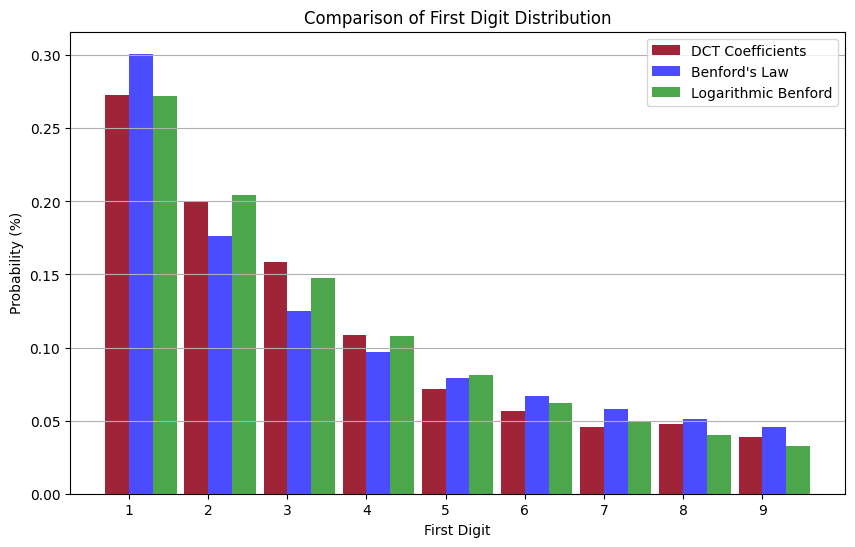

In [13]:
# Plot the probabilities side by side with Benford's Law
import matplotlib.pyplot as plt
import numpy as np

# Benford's Law distribution
DIGITS = np.arange(1, 10)
BENFORD = np.log10(1 + 1 / DIGITS)

# Define bar width and positions
bar_width = 0.3

plt.figure(figsize=(10, 6))

# Plot the first distribution
plt.bar(
    DIGITS - bar_width / 2,
    mean_probabilities,
    width=bar_width,
    color="#a02437",
    label="DCT Coefficients",
)

# Plot Benford's Law distribution
plt.bar(
    DIGITS + bar_width / 2,
    BENFORD,
    width=bar_width,
    color="blue",
    alpha=0.7,
    label="Benford's Law",
)

# Plot logarithmic Benford distribution

# Q factor = 70
# N = 5.35736274
# q = 1.91496246
# s = 6.94208667

# Q factor = 75
# N = 5.30554254
# q = 1.910744
# s = 6.85574919

# Q factor = 80
# N = 5.48227842
# q = 1.92193214
# s = 7.20938869

# Q factor = 90
# N = 3.85666179
# q = 1.77454821
# s = 4.16778882

# Q factor = 95
# N = 1.80904931
# q = 1.28458466
# s = 1.29845904

# Q factor = 98
N = 4.97227351
q = 1.85334686
s = 6.45064833

# Q factor = 99
# N = 1.55282627
# q = 1.29983359
# s = 0.62188549

LOG_BENFORD = N * np.log10(1 + 1 / (s + np.pow(DIGITS, q)))

plt.bar(
    DIGITS + 1.5 * bar_width,
    LOG_BENFORD,
    width=bar_width,
    color="green",
    alpha=0.7,
    label="Logarithmic Benford",
)

# Add labels, title, and legend
plt.xticks(DIGITS)
plt.xlabel("First Digit")
plt.ylabel("Probability (%)")
plt.title("Comparison of First Digit Distribution")
plt.legend()
plt.grid(axis="y")
plt.savefig("qf75.pdf", format="pdf")

plt.show()


In [14]:
# Attempt to curve fit the data to a polynomial
from scipy.optimize import curve_fit


def log_benford_func(x, N, q, s):
    return N * np.log10(1 + 1 / (s + np.pow(x, q)))


x = np.arange(1, 10)
y = mean_probabilities

# Fit the data to the polynomial
popt, pcov = curve_fit(log_benford_func, x, y, p0=[1, 1, 0])
ic(popt, pcov)

ic| popt: array([4.97227351, 1.85334686, 6.45064833])
    pcov: array([[1.77713323, 0.21079661, 2.96410288],
                 [0.21079661, 0.02630272, 0.34932537],
                 [2.96410288, 0.34932537, 4.98389661]])


(array([4.97227351, 1.85334686, 6.45064833]),
 array([[1.77713323, 0.21079661, 2.96410288],
        [0.21079661, 0.02630272, 0.34932537],
        [2.96410288, 0.34932537, 4.98389661]]))